# LEAN DATA SET APPROACH:

**We will try to fail fast and cheap by quickly building a working end-to-end pipeline (Build). Then, we will instrument the system to evaluate its performance (Measure). Finally, we will make incremental changes to improve the system's performance (Learn). Note that this practical methodology was adapted from Goodfellow et al. (2016), a book you can access for free here.**

## STEP:1 Imports and Utility functions for plotting

In [2]:
# Importing python built-in and Scikit related libraries
import pandas as pd #for dataframes and analysis
import numpy as np #for calculations using vecs, matrices
import seaborn as sns #for plotting like hist, dist, bar etc
import matplotlib.pyplot as plt #make built-in plots as well provide support to seaborn package libraries
#matplotlib inline #activate matplotlib plotting over cell in the notbook

#Scikit libraries
from sklearn.model_selection import train_test_split # split the data for cross validation purpose
from sklearn.model_selection import learning_curve # for plotting comparison scores training and test (Cross-val-score)
from sklearn.model_selection import validation_curve  # for plotting comparison scores training and test (Cross-val-score)
from sklearn.model_selection import cross_val_score # for computing cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression # Importing model

### STEP 1.1: Utility Functions

In [72]:
#1 Missing values tally DF
def draw_missing_data_table(df):
    missing=df.isnull().sum().sort_values(ascending=False )# Get the missing values for each column, which will represented as index in the df
    percents=(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False) # Get the percents for the missing values
    missing_data = pd.concat([missing, percents], axis=1, keys=['Total', 'Percent'])
    return missing_data

#2 Plot Learning Curve
def plot_learning_curve(estimator,
                                        title,
                                        X, y,
                                        ylim=None,
                                        cv=None,
                                        n_jobs = 1,
                                    train_sizes=np.linspace(0.1,1.0, 5)):

                                        # Create Fig obj with trivial settings
                                        plt.figure() # create fig obj
                                        plt.title(title) # set title for the fig
                                        plt.grid()
                                        if ylim is not None: # set the ylim if yli
                                            plt.ylim(*ylim)
                                        plt.xlabel("Training examples")
                                        plt.ylabel("Score")

                                        # get train_size, train_scores, test_scores
                                        train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs= n_jobs, train_sizes = train_sizes)

                                        # get parameters Mu, sigma for Train, Test data
                                        train_scores_mean = np.mean(train_scores, axis= 1)
                                        test_scores_mean = np.mean(test_scores, axis= 1)
                                        train_scores_std = np.std(train_scores, axis= 1)
                                        test_scores_std = np.std(test_scores, axis= 1)

                                        # Set the fill
                                        plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha = 0.2, color='r')
                                        plt.fill_between(train_sizes, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, alpha = 0.2, color='g')
                                        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
                                        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")
                                        plt.legend(loc="best")
                                        return plt
                                        
#3 Plot Validation Curve
def plot_validation_curve(estimator, 
                                          title, 
                                         X, y, 
                                         param_name, 
                                         param_range, 
                                         ylim=None, 
                                         cv=None,
                                        n_jobs=1, 
                                        train_sizes=np.linspace(.1, 1.0, 5)):
    
    # get train_size, train_scores, test_scores                                    
    train_scores, test_scores = validation_curve(estimator, X, y, param_name, param_range, cv)
   
    # get parameters Mu, sigma for Train, Test data
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot and set fill, labels, legend
    plt.plot(param_range, train_mean, color='r', marker='o', markersize=5, label='Training score')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='r')
    plt.plot(param_range, test_mean, color='g', linestyle='--', marker='s', markersize=5, label='Validation score')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='g')
    plt.grid() 
    plt.xscale('log')
    plt.legend(loc='best') 
    plt.xlabel('Parameter') 
    plt.ylabel('Score') 
    plt.ylim(ylim)




## STEP 1.2: Import Data and begin Exploratory Data Analysis

### Read data


In [48]:
df = pd.read_csv("../titanic_data/train.csv")
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [49]:
# Just make a copy incase we mess up original data
df_raw=df.copy()

Definitions and quick thoughts:

* PassengerId. Unique identification of the passenger. It shouldn't be necessary for the machine learning model.
* Survived. Survival (0 = No, 1 = Yes). Binary variable that will be our target variable.
* Pclass. Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd). Ready to go.
* Name. Name of the passenger. We need to parse before using it.
* Sex. Sex. Categorical variable that should be encoded.
* Age. Age in years. Ready to go.
* SibSp. # of siblings / spouses aboard the Titanic. Ready to go.
* Parch. # of parents / children aboard the Titanic. Ready to go.
* Ticket. Ticket number. Big mess. We need to understand its structure first.
* Fare. Passenger fare. Ready to go.
* Cabin. Cabin number. It needs to be parsed.
* Embarked. Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton). Categorical feature that should be encoded.
### The main conclusion is that we already have a set of features that we can easily use in our machine learning model. Other features, like 'Name', 'Ticket', and 'Fare', require an additional effort before we can integrate them.


In [50]:
# Get descriptive stats to begin with
df.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

here are three aspects that usually catch my attention when I analyse descriptive statistics:

- _Min and max values_. This can give us an idea about the range of values and is helpful to detect outliers. In our case, all the min and max values seem reasonable and in a reasonable range of values. **The only exception could eventually be the max value of 'Fare', but for now we will leave it as it is.**
- _Mean and standard deviation_. The mean shows us the central tendency of the distribution, while the standard deviation quantifies its amount of variation. For example, a low standard deviation suggests that data points tend to be close to the mean. Giving a quick look to our values, there's nothing that looks like obviously wrong.
- _Count_. This is important to give us a first perception about the volume of missing data. **Here, we can see that some 'Age' data is missing.**
Since there's nothing shocking about the variables, let's proceed to the next step: missing data.

### Filling the gaps - Missing value treatment


There are several strategies to deal with missing data. Some of the most common are:

- Use only valid data, deleting the cases where data is missing.
- Impute data using values from similar cases or using the mean value.
- Impute data using model-based methods, in which models are defined to predict the missing values.

Now that we can see the tip of the iceberg, let's dive into the subject.

In [51]:
# Analyse missing data
draw_missing_data_table(df) # to deal with missing values here we would like to remove variables with more the 25% missing values, here that variable can be 'Cabin'

Total   Percent
Cabin          687  0.771044
Age            177  0.198653
Embarked         2  0.002245
Fare             0  0.000000
Ticket           0  0.000000
Parch            0  0.000000
SibSp            0  0.000000
Sex              0  0.000000
Name             0  0.000000
Pclass           0  0.000000
Survived         0  0.000000
PassengerId      0  0.000000

First thoughts:

- 'Cabin' has **too many missing values (>25%).** Dogma! We need to delete this variable right away.
- 'Age' can be imputed. For now, **I'll associate a value that allows me to know that I'm imputing data.** Later, I'll revise this strategy.
- Due to the low percentage of missing values, **I'll delete the observations where we don't know 'Embarked'.**

In [52]:
# Drop Cabin
df.drop('Cabin', axis=1, inplace=True)
df.head()



PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Embarked  
0      0         A/5 21171   7.2500        S  
1      0          PC 17599  71.2833        C  
2      0  STON/O2. 3101282   7.9250        S  
3      0            113803  53.1000        S  
4      0            373450   8.0500        S

In [53]:
# Fill missing values in Age with a specific value
value = 1000
df['Age'].fillna(1000, inplace=True)
df['Age'].max()


1000.0

In [54]:
# Delete observations without Embarked
df.drop(df[pd.isnull(df['Embarked'])].index, inplace=True)  # Get index of points where Embarked is null
df[pd.isnull(df['Embarked'])]

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Embarked]
Index: []

### Data Preparation for ML models


In [55]:
# Data types
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

#### Key Points:
- We don't need 'PassengerId' for prediction purposes, so we will **exclude** it.
- 'Sex', 'Embarked', and 'Pclass' should be categorical. **I'll not consider 'Survived' as categorical because it's the output variable.**
- We **need to parse 'Name' and 'Ticket'. For now, I'll ignore these features.**
- 'SibSp' could be grouped with 'Parch' to create a 'Family' feature. **For now, I'll just identify if the passenger is travelling alone or with family.**

In [56]:
# Drop PassengerId
df.drop('PassengerId', axis=1, inplace=True)
df.head()

Survived  Pclass                                               Name  \
0         0       3                            Braund, Mr. Owen Harris   
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2         1       3                             Heikkinen, Miss. Laina   
3         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4         0       3                           Allen, Mr. William Henry   

      Sex   Age  SibSp  Parch            Ticket     Fare Embarked  
0    male  22.0      1      0         A/5 21171   7.2500        S  
1  female  38.0      1      0          PC 17599  71.2833        C  
2  female  26.0      0      0  STON/O2. 3101282   7.9250        S  
3  female  35.0      1      0            113803  53.1000        S  
4    male  35.0      0      0            373450   8.0500        S

In [57]:
# Define categorical variables
df['Sex'] = pd.Categorical(df['Sex'])
df['Embarked'] = pd.Categorical(df['Embarked'])
df.head()

Survived  Pclass                                               Name  \
0         0       3                            Braund, Mr. Owen Harris   
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2         1       3                             Heikkinen, Miss. Laina   
3         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4         0       3                           Allen, Mr. William Henry   

      Sex   Age  SibSp  Parch            Ticket     Fare Embarked  
0    male  22.0      1      0         A/5 21171   7.2500        S  
1  female  38.0      1      0          PC 17599  71.2833        C  
2  female  26.0      0      0  STON/O2. 3101282   7.9250        S  
3  female  35.0      1      0            113803  53.1000        S  
4    male  35.0      0      0            373450   8.0500        S

In [58]:
# Create Family feature
df['FamilySize'] = df['SibSp'] + df['Parch']
df.head()

Survived  Pclass                                               Name  \
0         0       3                            Braund, Mr. Owen Harris   
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2         1       3                             Heikkinen, Miss. Laina   
3         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4         0       3                           Allen, Mr. William Henry   

      Sex   Age  SibSp  Parch            Ticket     Fare Embarked  FamilySize  
0    male  22.0      1      0         A/5 21171   7.2500        S           1  
1  female  38.0      1      0          PC 17599  71.2833        C           1  
2  female  26.0      0      0  STON/O2. 3101282   7.9250        S           0  
3  female  35.0      1      0            113803  53.1000        S           1  
4    male  35.0      0      0            373450   8.0500        S           0

In [59]:
# Drop SibSp and Parch
df.drop('SibSp',axis=1,inplace=True)
df.drop('Parch',axis=1,inplace=True)
df.head()

Survived  Pclass                                               Name  \
0         0       3                            Braund, Mr. Owen Harris   
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2         1       3                             Heikkinen, Miss. Laina   
3         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4         0       3                           Allen, Mr. William Henry   

      Sex   Age            Ticket     Fare Embarked  FamilySize  
0    male  22.0         A/5 21171   7.2500        S           1  
1  female  38.0          PC 17599  71.2833        C           1  
2  female  26.0  STON/O2. 3101282   7.9250        S           0  
3  female  35.0            113803  53.1000        S           1  
4    male  35.0            373450   8.0500        S           0

In [60]:
# Drop Name and Ticket
df.drop('Name', axis=1, inplace=True)
df.drop('Ticket', axis=1, inplace=True)
df.head()

Survived  Pclass     Sex   Age     Fare Embarked  FamilySize
0         0       3    male  22.0   7.2500        S           1
1         1       1  female  38.0  71.2833        C           1
2         1       3  female  26.0   7.9250        S           0
3         1       1  female  35.0  53.1000        S           1
4         0       3    male  35.0   8.0500        S           0

In [61]:
# Transform categorical variables into dummy variables
df = pd.get_dummies(df, drop_first=True)  # To avoid dummy trap
df.head()

Survived  Pclass   Age     Fare  FamilySize  Sex_male  Embarked_Q  \
0         0       3  22.0   7.2500           1         1           0   
1         1       1  38.0  71.2833           1         0           0   
2         1       3  26.0   7.9250           0         0           0   
3         1       1  35.0  53.1000           1         0           0   
4         0       3  35.0   8.0500           0         1           0   

   Embarked_S  
0           1  
1           0  
2           1  
3           1  
4           1

## STEP 1.3: Create Machine learning models on data

In [62]:
# Create data set to train data imputation methods
X = df[df.loc[:, df.columns != 'Survived'].columns] # leaving out target
y = df['Survived'] # target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1) # Split data for cross validation purpose

In [63]:
# Debug
print('Inputs: \n', X_train.head())
print('Outputs: \n', y_train.head())

Inputs: 
      Pclass     Age      Fare  FamilySize  Sex_male  Embarked_Q  Embarked_S
121       3  1000.0    8.0500           0         1           0           1
687       3    19.0   10.1708           0         1           0           1
790       3  1000.0    7.7500           0         1           1           0
837       3  1000.0    8.0500           0         1           0           1
659       1    58.0  113.2750           2         1           0           0
Outputs: 
 121    0
687    0
790    0
837    0
659    0
Name: Survived, dtype: int64


In [65]:
# Fit logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [66]:
# Model performance
scores = cross_val_score(logreg, X_train, y_train, cv=10)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.786 +/- 0.026


In [70]:
pd.DataFrame(scores, columns=['Scores'],index=['Iteration-'+str(i) for i in range(1,11)])

Scores
Iteration-1   0.791667
Iteration-2   0.819444
Iteration-3   0.763889
Iteration-4   0.763889
Iteration-5   0.788732
Iteration-6   0.774648
Iteration-7   0.746479
Iteration-8   0.814286
Iteration-9   0.771429
Iteration-10  0.828571

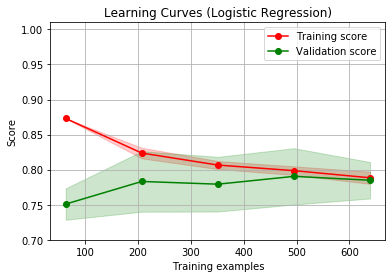

In [73]:
# Plot learning curves
title = "Learning Curves (Logistic Regression)"
cv = 10
plot_learning_curve(logreg, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=1);

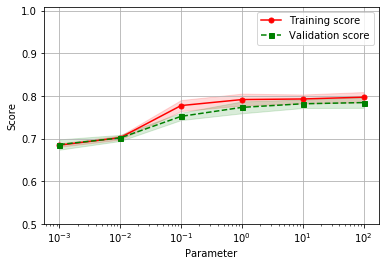

In [74]:
# Plot validation curve
title = 'Validation Curve (Logistic Regression)'
param_name = 'C'
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
cv = 10
plot_validation_curve(estimator=logreg, title=title, X=X_train, y=y_train, param_name=param_name,
                      ylim=(0.5, 1.01), param_range=param_range);

## SUMMARY (Lean Data Set Approach):
learning_curve helps improves the performance by choosing approp. sample size for cross validation, and observed performance can be further optimized by choosing appro. parameters under cv (using validation_curve) 

# CHUBBY DATA SET APPROACH:


At this point, our model:

- Can achieve a 0.786 +/- 0.026 accuracy.
- Is based on a logistic regression.
- Uses 'Pclass', 'Age', 'Fare', 'FamilySize', 'Sex', and 'Embarked as inputs; and 'Survived' as output.

Moreover, concerning the practical methodology that we mentioned before, we can say that:

- The choice of the performance metric is a closed topic because we're following Kaggle's specifications.
- Our current model can work as a baseline model and resulted from a working end-to-end pipeline.
- The learning and validation curves allow us to monitor system's performance.
As a consequence, only the fourth and last step of the practical methodology is missing: to improve the model by iteration. This can be done by:

Improving the way how we handled 'Age' missing data. In our lean approach we decided to replace missing data by a unique value, but now we can go deeper and search for a better imputation strategy.
Exploring data to understand which features can have impact in the model and how they can be manipulated to boost that impact.

**Building new features that can increase the predictive power of our model.
This will lead us to a heavy data analysis process, which aims to improve model's performance just by the data quality side. In other words, we will not change our learning algorithm neither we will try to improve its parameters. We will only try to improve the performance of our model by enriching our data.
**
That said, let's say goodbye to the lean approach and welcome the chubby approach!

In [25]:


In [76]:
## Restart data set
df = df_raw.copy()
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [77]:
# Family size feature
df['FamilySize'] = df['SibSp'] + df['Parch']
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  FamilySize  
0      0         A/5 21171   7.2500   NaN        S           1  
1      0          PC 17599  71.2833   C85        C           1  
2      0  STON/O2. 3101282   7.9250   NaN        S           0  
3      0            113803  53.1000  C123        S           1  
4      0            373450   8.0500   NaN        S           0

In [78]:
# Drop SibSp and Parch
df.drop('SibSp',axis=1,inplace=True)
df.drop('Parch',axis=1,inplace=True)
df.head()


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  \
0                            Braund, Mr. Owen Harris    male  22.0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
2                             Heikkinen, Miss. Laina  female  26.0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
4                           Allen, Mr. William Henry    male  35.0   

             Ticket     Fare Cabin Embarked  FamilySize  
0         A/5 21171   7.2500   NaN        S           1  
1          PC 17599  71.2833   C85        C           1  
2  STON/O2. 3101282   7.9250   NaN        S           0  
3            113803  53.1000  C123        S           1  
4            373450   8.0500   NaN        S           0

In [79]:
# Drop irrelevant features
df.drop(['Name','Ticket','Cabin'], axis=1, inplace=True)
df.head()

PassengerId  Survived  Pclass     Sex   Age     Fare Embarked  FamilySize
0            1         0       3    male  22.0   7.2500        S           1
1            2         1       1  female  38.0  71.2833        C           1
2            3         1       3  female  26.0   7.9250        S           0
3            4         1       1  female  35.0  53.1000        S           1
4            5         0       3    male  35.0   8.0500        S           0

### Imputation of Age Variable

Our initial approach to estimate 'Age' missing values was to fill with a placeholder value (1000). This allowed us to quickly get a complete data set, in which was easy to identify imputed values. Since our goal was to have a working end-to-end pipeline as fast as possible, this approach was ok. 

However, it has several limitations. For example, **we are using unrealistic replacement values, which are out of range and distort data distribution.** Accordingly, now that we are improving the model, it makes sense to develop a different imputation method.

**One way to improve our imputation method is to estimate the missing values based on known relationships.** In our case, we can do this by using the information in the variable 'Name'. Looking to 'Name' values, we can see person's name and title. Person's title is a relevant information to estimate ages. To give an example, we know that a person with the title 'Master' is someone under 13 years old, since 'a boy can be addressed as master only until age 12'. Therefore, **employing the information in 'Name' we can improve our imputation method.**

The steps to implement this new imputation method are:

* Extract titles from 'Name'.
* Plot a figure with both features and confirm that there is a connection between titles and age.
* For each title, get people's average age and use it to fill missing values.
Let's see how this work, before you start with sinking feelings.

In [80]:
# Inspect names
df_raw['Name'].unique()[:10]

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)'], dtype=object)

In [81]:
# Extract titles from name
df['Title']=0
for i in df:
    df['Title']=df_raw['Name'].str.extract('([A-Za-z]+)\.', expand=False)  # Use REGEX to define a search pattern
df.head()

PassengerId  Survived  Pclass     Sex   Age     Fare Embarked  FamilySize  \
0            1         0       3    male  22.0   7.2500        S           1   
1            2         1       1  female  38.0  71.2833        C           1   
2            3         1       3  female  26.0   7.9250        S           0   
3            4         1       1  female  35.0  53.1000        S           1   
4            5         0       3    male  35.0   8.0500        S           0   

  Title  
0    Mr  
1   Mrs  
2  Miss  
3   Mrs  
4    Mr

In [82]:
# Unique titles
df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

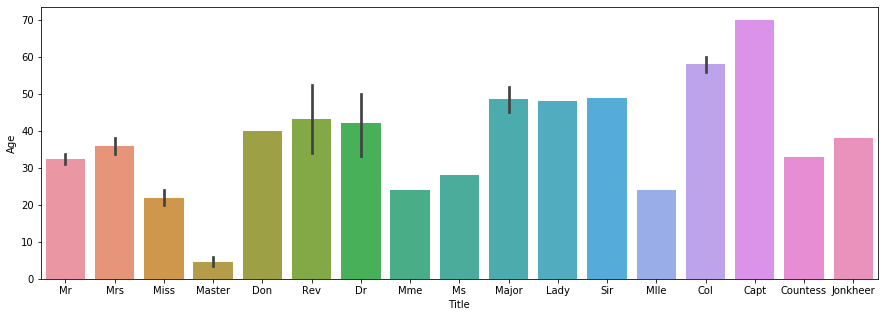

In [83]:
# Plot bar plot (titles, age and sex)
plt.figure(figsize=(15,5))
sns.barplot(x=df['Title'], y=df_raw['Age']);

In [84]:
# Means per title
df_raw['Title'] = df['Title']  # To simplify data handling
means = df_raw.groupby('Title')['Age'].mean()
means.head()

Title
Capt        70.0
Col         58.0
Countess    33.0
Don         40.0
Dr          42.0
Name: Age, dtype: float64

In [85]:
# Transform means into a dictionary for future mapping
map_means = means.to_dict()
map_means

{'Capt': 70.0,
 'Col': 58.0,
 'Countess': 33.0,
 'Don': 40.0,
 'Dr': 42.0,
 'Jonkheer': 38.0,
 'Lady': 48.0,
 'Major': 48.5,
 'Master': 4.574166666666667,
 'Miss': 21.773972602739725,
 'Mlle': 24.0,
 'Mme': 24.0,
 'Mr': 32.368090452261306,
 'Mrs': 35.898148148148145,
 'Ms': 28.0,
 'Rev': 43.166666666666664,
 'Sir': 49.0}

In [86]:
# Impute ages based on titles
idx_nan_age = df.loc[np.isnan(df['Age'])].index
df.loc[idx_nan_age,'Age'].loc[idx_nan_age] = df['Title'].loc[idx_nan_age].map(map_means)
df.head()

PassengerId  Survived  Pclass     Sex   Age     Fare Embarked  FamilySize  \
0            1         0       3    male  22.0   7.2500        S           1   
1            2         1       1  female  38.0  71.2833        C           1   
2            3         1       3  female  26.0   7.9250        S           0   
3            4         1       1  female  35.0  53.1000        S           1   
4            5         0       3    male  35.0   8.0500        S           0   

  Title  
0    Mr  
1   Mrs  
2  Miss  
3   Mrs  
4    Mr

In [90]:
# Identify imputed data
df['Imputed'] = 0
df.at[idx_nan_age.values, 'Imputed'] = 1
df.head()

PassengerId  Survived  Pclass     Sex   Age     Fare Embarked  FamilySize  \
0            1         0       3    male  22.0   7.2500        S           1   
1            2         1       1  female  38.0  71.2833        C           1   
2            3         1       3  female  26.0   7.9250        S           0   
3            4         1       1  female  35.0  53.1000        S           1   
4            5         0       3    male  35.0   8.0500        S           0   

  Title  Imputed  
0    Mr        0  
1   Mrs        0  
2  Miss        0  
3   Mrs        0  
4    Mr        0

Ok, now that I convinced you that the hypothesis driven approach is the last coke in the desert, let me show you how to apply it. **Cases like the one we have are easy targets for the hypothesis driven approach because we don't have many variables, so we can more or less guess their impact.** Accordingly, we will start by listing each of the variables and generate hypothesis about their relationship with the target variable ('Survived'). Then, we will test those hypothesis through a set of exploratory data analysis tools. As a result, we'll end up with a comprehensive view about the variables that should belong to our prediction model.

Let's get started:

* PassengerId. This is just an unique identification of each passenger. It's not expected to be relevant to our analysis.
* Survived. Target variable. To sink or not to sink is the question of this exercise.
* Pclass. This is the ticket class. According to Karl Marx, this should affect our target variable. First class should have a higher survival rate.
* Name. Names are a form of social tagging, especially when accompanied by a  title. As a consequence, it can lead to different forms of treatment. Let's keep an eye on this.
* Sex. Always important.
* Age. It should make a difference. For example, children are usually evacuated first in a disaster, so that we can think about a solution in silence... Joking, the true reason why 'Age' matters is this one.
* SibSp. Number of siblings/spouses aboard the Titanic. I'd say that it's easier to survive if you're with your family than if you're travelling alone. Teamwork!
* Parch. Number of parents/children aboard the Titanic. It should play with 'SibSp'.
* Ticket. This is the ticket number. Unless it has some information about places, it shouldn't be important for prediction purposes.
* Fare. Same logic as 'Pclass'.
* Cabin. The cabin number can indicate where people were during the disaster. It wouldn't be surprising if it had some influence in survival chances, but this variable was excluded due to the high percentage of missing values.
* Embarked. When the sun rises, it rises for everyone. It's not expectable that people coming from Cherbourg are more unlucky than people coming from Southampton. Unless there is some second order effect, like refusing to run away to keep your honor as a man, I would say that this variable is not important.
Now, step by step, let's perform our analysis.
df.head()

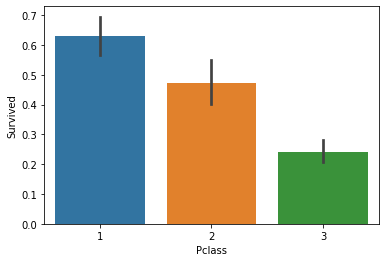

In [92]:
# Plot
sns.barplot(df['Pclass'],df['Survived']);

In [93]:
# Count how many people have each of the titles
df.groupby(['Title'])['PassengerId'].count()

Title
Capt          1
Col           2
Countess      1
Don           1
Dr            7
Jonkheer      1
Lady          1
Major         2
Master       40
Miss        182
Mlle          2
Mme           1
Mr          517
Mrs         125
Ms            1
Rev           6
Sir           1
Name: PassengerId, dtype: int64

In [94]:
# Map of aggregated titles:
titles_dict = {'Capt': 'Other',
               'Major': 'Other',
               'Jonkheer': 'Other',
               'Don': 'Other',
               'Sir': 'Other',
               'Dr': 'Other',
               'Rev': 'Other',
               'Countess': 'Other',
               'Dona': 'Other',
               'Mme': 'Mrs',
               'Mlle': 'Miss',
               'Ms': 'Miss',
               'Mr': 'Mr',
               'Mrs': 'Mrs',
               'Miss': 'Miss',
               'Master': 'Master',
               'Lady': 'Other'}

In [95]:
# Group titles
df['Title'] = df['Title'].map(titles_dict)
df['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [96]:
# Transform into categorical
df['Title'] = pd.Categorical(df['Title'])
df.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Sex              object
Age             float64
Fare            float64
Embarked         object
FamilySize        int64
Title          category
Imputed           int64
dtype: object

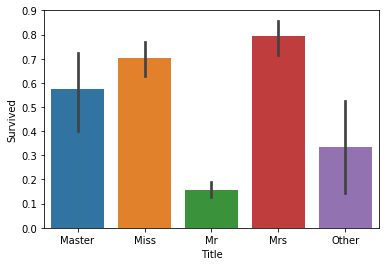

In [97]:
# Plot
sns.barplot(x='Title', y='Survived', data=df);

Our new category, 'Other', should be more discretized. As we can see by the error bar (black line), **there is a significant uncertainty around the mean value. Probably, one of the problems is that we are mixing male and female titles in the 'Other' category.** We should proceed with a more detailed analysis to sort this out. Also, the category 'Master' seems to have a similar problem. For now, we will not make any changes, but we will keep these two situations in our mind for future improvement of our data set.

In [98]:
# Transform into categorical
df['Sex'] = pd.Categorical(df['Sex'])

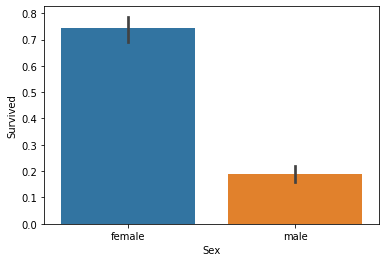

In [99]:
# Plot
sns.barplot(df['Sex'],df['Survived']);

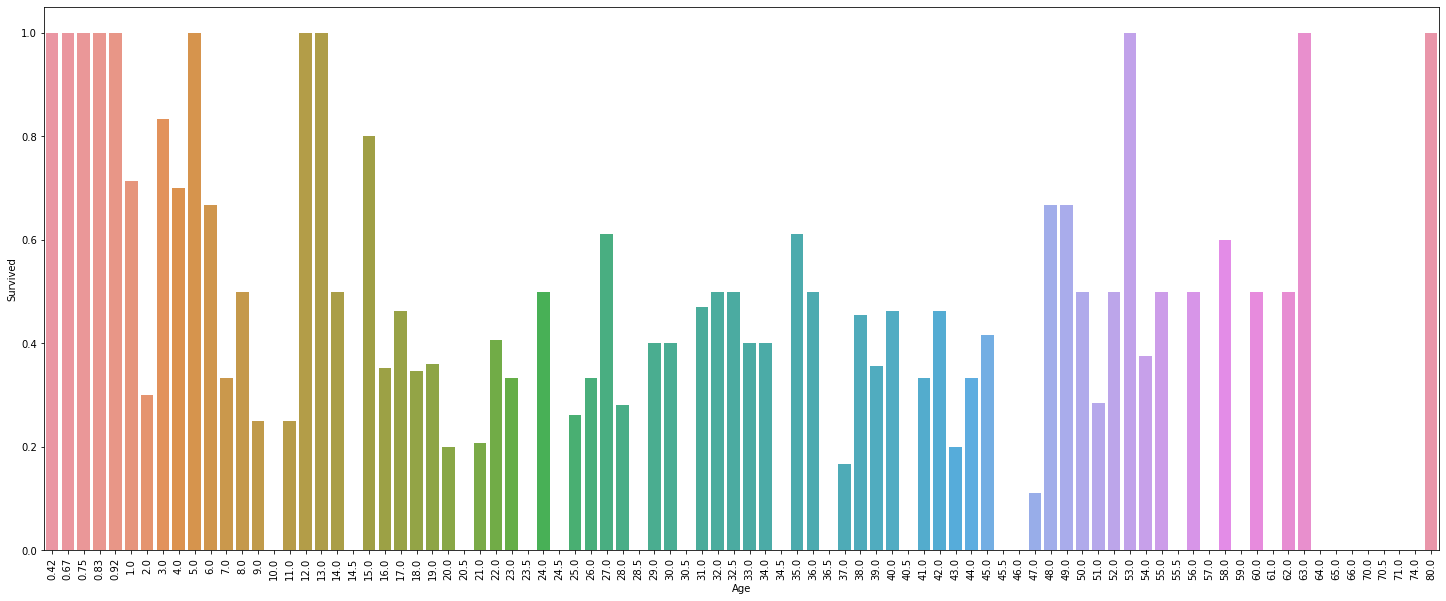

In [100]:
# Plot
plt.figure(figsize=(25,10))
sns.barplot(df['Age'],df['Survived'], ci=None)
plt.xticks(rotation=90);

I know that this division is arguable, especially in what concerns the last two categories. However, the point is that this categories split fits into what we know about the way our society is organized: childrens, adults and elders. For now, let's proceed this way.

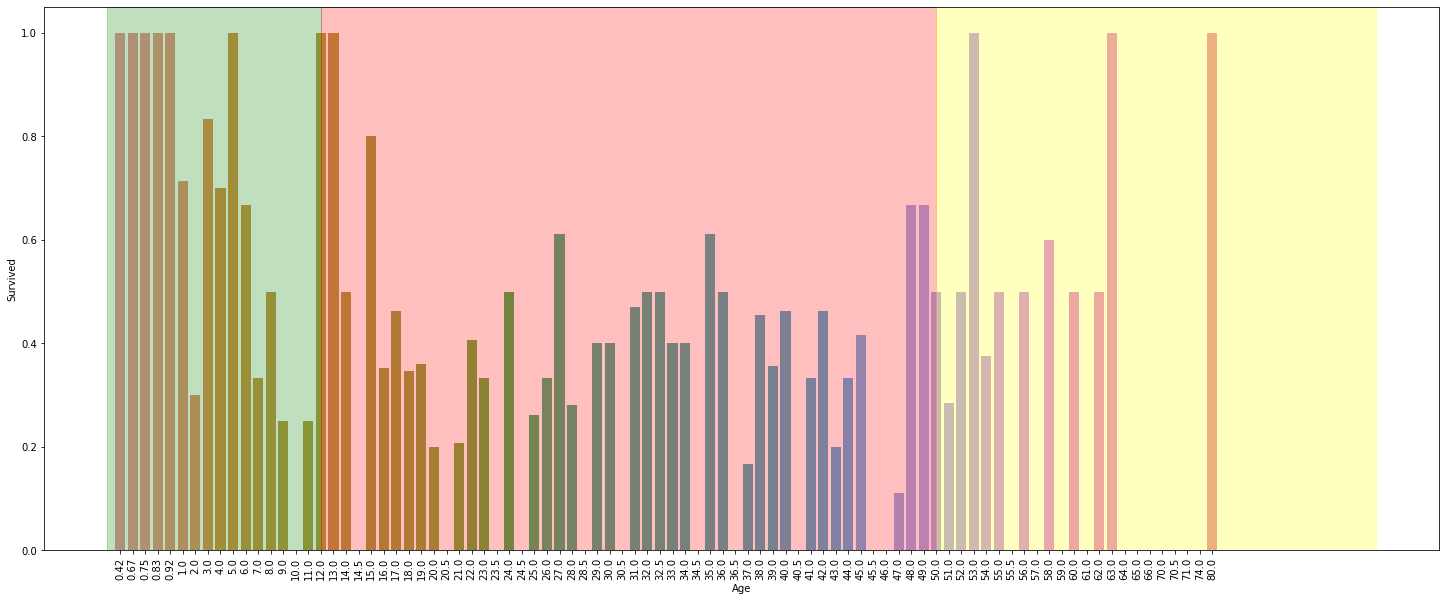

In [101]:
# Plot
'''
Probably, there is an easier way to do this plot. I had a problem using
plt.axvspan because the xmin and xmax values weren't
being plotted correctly. For example, I would define xmax = 12 and only 
the area between 0 and 7 would be filled. This was happening because my 
X-axis don't follow a regular (0, 1, ..., n) sequence. After some trial
and error, I noticed that xmin and xmax refer to the number of elements in
the X-axis coordinate that should be filled. Accordingly, I defined two 
variables, x_limit_1 and x_limit_2, that count the number of elements that
should be filled in each interval. Sounds confusing? To me too.
'''
limit_1 = 12
limit_2 = 50

x_limit_1 = np.size(df[df['Age'] < limit_1]['Age'].unique())
x_limit_2 = np.size(df[df['Age'] < limit_2]['Age'].unique())

plt.figure(figsize=(25,10))
sns.barplot(df['Age'],df['Survived'], ci=None)

plt.axvspan(-1, x_limit_1, alpha=0.25, color='green')
plt.axvspan(x_limit_1, x_limit_2, alpha=0.25, color='red')
plt.axvspan(x_limit_2, 100, alpha=0.25, color='yellow')

plt.xticks(rotation=90);


In [104]:
# Bin data
df['Age'] = pd.cut(df['Age'], bins=[0, 12, 50, 200], labels=['Child','Adult','Elder'])
df['Age'].head()

0    Adult
1    Adult
2    Adult
3    Adult
4    Adult
Name: Age, dtype: category
Categories (3, object): [Child < Adult < Elder]

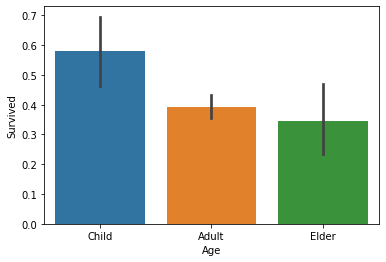

In [105]:
# Plot
sns.barplot(df['Age'], df['Survived']);


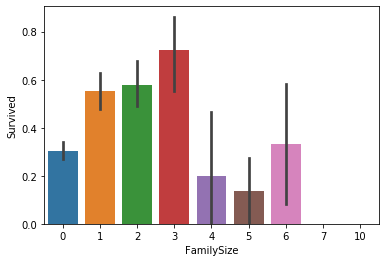

In [106]:
# Plot
sns.barplot(df['FamilySize'], df['Survived']);

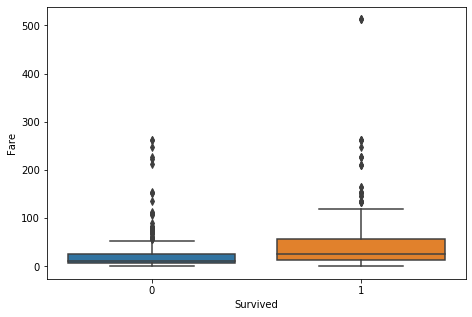

In [107]:
# Plot
plt.figure(figsize=(7.5,5))
sns.boxplot(df['Survived'], df['Fare']);

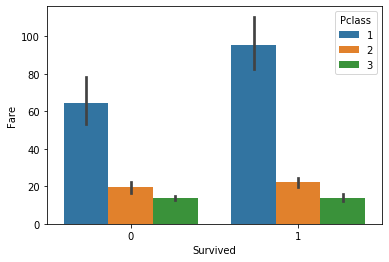

In [108]:
# Plot
sns.barplot(df['Survived'], df['Fare'], df['Pclass']);

Here we have an interesting result. It seems that 'Fare' doesn't make difference, in terms of survival, if you are travelling in second or third class. However, if you are travelling in first class, the higher the fare, the higher the chances of survival. Considering this, it would make sense to create interaction features between 'Fare' and 'Pclass'.

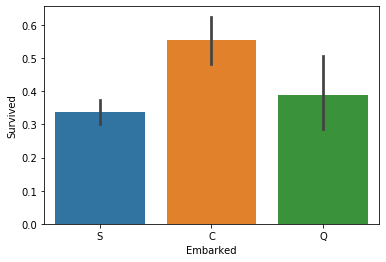

In [109]:
# Plot
sns.barplot(df['Embarked'], df['Survived']);

In [111]:
# Compare with other variables
df.groupby(['Sex','Embarked']).mean()

PassengerId  Survived    Pclass       Fare  FamilySize  \
Sex    Embarked                                                           
female C          437.315068  0.876712  1.726027  75.169805    1.041096   
       Q          374.138889  0.750000  2.888889  12.634958    0.444444   
       S          438.709360  0.689655  2.197044  38.740929    1.625616   
male   C          451.536842  0.305263  2.010526  48.262109    0.526316   
       Q          456.317073  0.073171  2.926829  13.838922    0.731707   
       S          454.507937  0.174603  2.421769  21.711996    0.689342   

                  Imputed  
Sex    Embarked            
female C         0.164384  
       Q         0.666667  
       S         0.083744  
male   C         0.273684  
       Q         0.609756  
       S         0.165533

It seems that people embarking on C were paying more and travelling in a better class than people embarking on Q and S.

In [113]:
# Relationship with age
df.groupby(['Embarked','Age'])['PassengerId'].count()

Embarked  Age  
C         Child     11
          Adult    104
          Elder     15
Q         Child      4
          Adult     21
          Elder      3
S         Child     54
          Adult    455
          Elder     45
Name: PassengerId, dtype: int64

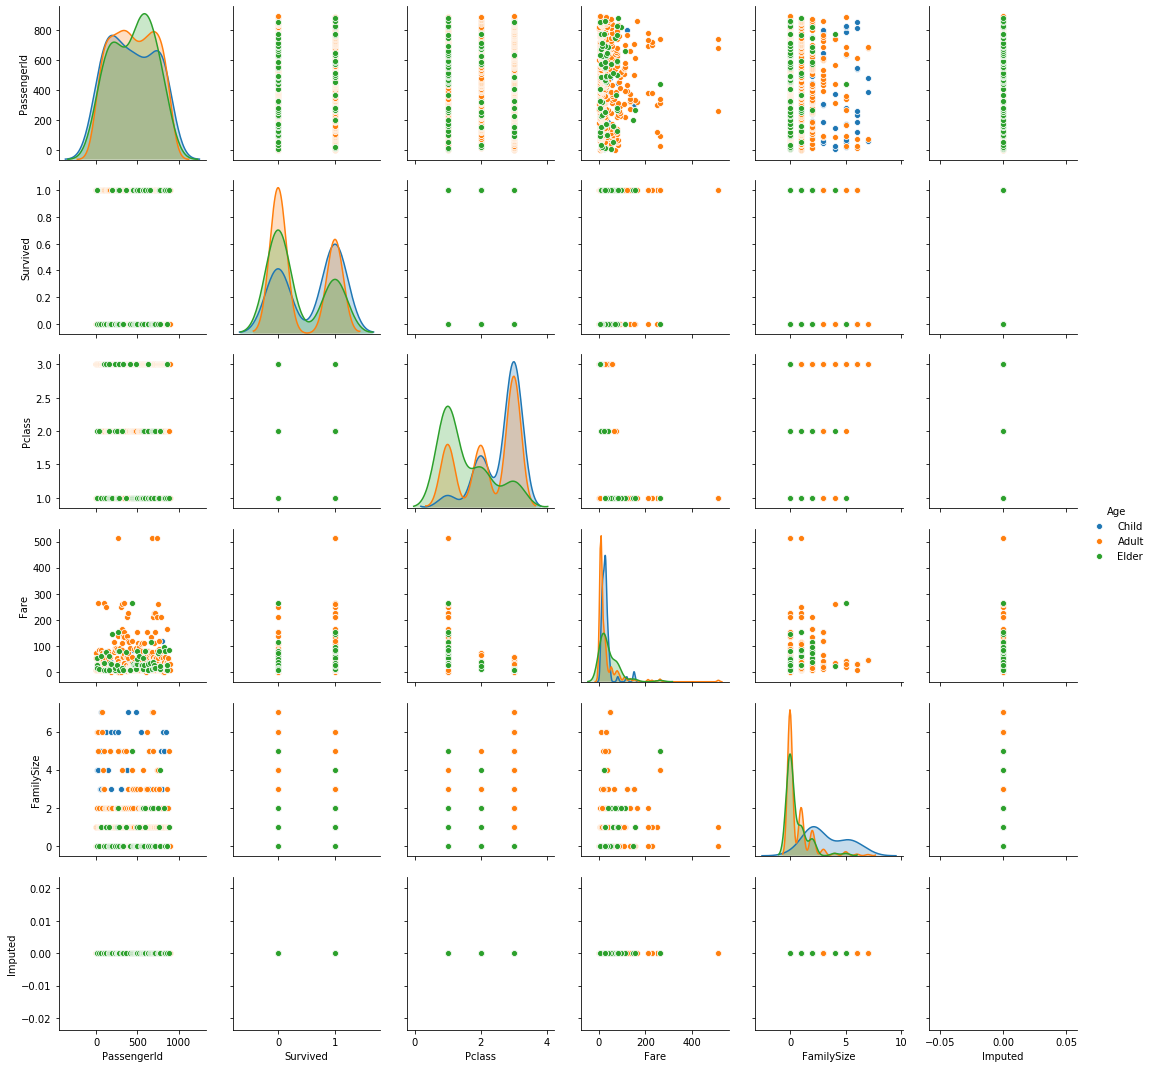

In [115]:
sns.pairplot(df,hue='Age')


## STEP 2.2: Feature engineering & Feature Selection


* Feature Engineering: Generation of Informative Features
* Feature Selection: Selection of relevant features (compact set)

### STEP 2.2.1 Feature engineering

Feature engineering is the art of converting raw data into useful features. There are several feature engineering techniques that you can apply to be an artist. A comprehensive list of them is presented by Heaton (2016). We will use just two techniques:

Box-Cox transformations (Box & Cox 1964);
Polynomials generation through non-linear expansions.
Before the application of these techniques, we will just make some adjustments to the data, in order to prepare it for the modelling process.

In [116]:
# Before applying feature engineering, make adjustments to the data
# Overview
df.head()

PassengerId  Survived  Pclass     Sex    Age     Fare Embarked  FamilySize  \
0            1         0       3    male  Adult   7.2500        S           1   
1            2         1       1  female  Adult  71.2833        C           1   
2            3         1       3  female  Adult   7.9250        S           0   
3            4         1       1  female  Adult  53.1000        S           1   
4            5         0       3    male  Adult   8.0500        S           0   

  Title  Imputed  
0    Mr        0  
1   Mrs        0  
2  Miss        0  
3   Mrs        0  
4    Mr        0

In [117]:
# Drop feature
df.drop('PassengerId', axis=1, inplace=True)

In [118]:
# Check features type
df.dtypes

Survived         int64
Pclass           int64
Sex           category
Age           category
Fare           float64
Embarked        object
FamilySize       int64
Title         category
Imputed          int64
dtype: object

In [119]:
# Transform object into categorical
df['Embarked'] = pd.Categorical(df['Embarked'])
df['Pclass'] = pd.Categorical(df['Pclass'])
df.dtypes

Survived         int64
Pclass        category
Sex           category
Age           category
Fare           float64
Embarked      category
FamilySize       int64
Title         category
Imputed          int64
dtype: object

In [120]:
# Transform categorical features into dummy variables
df = pd.get_dummies(df, drop_first=1)  
df.head()

Survived     Fare  FamilySize  Imputed  Pclass_2  Pclass_3  Sex_male  \
0         0   7.2500           1        0         0         1         1   
1         1  71.2833           1        0         0         0         0   
2         1   7.9250           0        0         0         1         0   
3         1  53.1000           1        0         0         0         0   
4         0   8.0500           0        0         0         1         1   

   Age_Adult  Age_Elder  Embarked_Q  Embarked_S  Title_Miss  Title_Mr  \
0          1          0           0           1           0         1   
1          1          0           0           0           0         0   
2          1          0           0           1           1         0   
3          1          0           0           1           0         0   
4          1          0           0           1           0         1   

   Title_Mrs  Title_Other  
0          0            0  
1          1            0  
2          0            0  
3          1            0  
4          0            0

## STEP 2.2.2: Split Training, test data

In [122]:
# Get training and test sets
from sklearn.model_selection import train_test_split

X = df[df.loc[:, df.columns != 'Survived'].columns]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

###  Box cox Transform

Box-Cox transformations aim to normalize variables. These transformations are an alternative to the typical transformations, such as square root transformations, log transformations, and inverse transformations. **The main advantage of Box-Cox transformations is that they optimally normalize the chosen variable. Thus, they avoid the need to randomly try different transformations and automatize the data transformation process.**

In [123]:
# Apply Box-Cox transformation
from scipy.stats import boxcox

X_train_transformed = X_train.copy()
X_train_transformed['Fare'] = boxcox(X_train_transformed['Fare'] + 1)[0]
X_test_transformed = X_test.copy()
X_test_transformed['Fare'] = boxcox(X_test_transformed['Fare'] + 1)[0]

Polynomials

- One standard way to enrich our set of features is to generate polynomials. Polynomial expansion creates interactions between features, as well as creates powers (e.g. square of a feature). **This way we introduce a nonlinear dimension to our data set, which can improve the predictive power of our model.**

- We should scale our features when we have polynomial or interaction terms in our model. **These terms tend to produce multicollinearity, which can make our estimates very sensitive to minor changes in the model. Scaling features to a range allow us to reduce multicollinearity and its problems.**

- To scale the features, we will transform the data so that it lies between a given minimum and maximum value. We will follow the common practice and say that our minimum value is zero, and our maximum value is one.

In [124]:
# Rescale data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_transformed_scaled = scaler.fit_transform(X_train_transformed)
X_test_transformed_scaled = scaler.transform(X_test_transformed)

In [127]:
# Get polynomial features
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2).fit(X_train_transformed)
X_train_poly = poly.transform(X_train_transformed_scaled)
X_test_poly = poly.transform(X_test_transformed_scaled)



In [128]:
# Debug
print(poly.get_feature_names())

['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x0 x13', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x1 x13', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x2 x12', 'x2 x13', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x3 x12', 'x3 x13', 'x4^2', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x4 x12', 'x4 x13', 'x5^2', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x5 x11', 'x5 x12', 'x5 x13', 'x6^2', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x6 x11', 'x6 x12', 'x6 x13', 'x7^2', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11', 'x7 x12', 'x7 x13', 'x8^2', 'x8 x9', 'x8 x10', 'x8 x11', 'x8 x12', 'x8 x13', 'x9^2', 'x9 x10', 'x9 x11', 'x9 x12', 'x9 x13', 'x10^2', 'x10 x11', '

The next step is to perform feature selection. Feature selection is about chosing the relevant information. It is good to add and generate features, but at some point we need to exclude irrelevant features. Otherwise, we will be penalizing the predictive power of our model. You can find a concise introduction to the feature selection subject in Guyon & Elisseeff (2003).

- In this work, we will use a _univariate statistics approach_. **This approach selects features based on univariate statistical tests between each feature and the target variable. The intuition is that features that are independent from the target variable, are irrelevant for classification.**

- We will use the _chi-squared test_ for feature selection. **This means that we have to choose the number of features that we want in the model. For example, if we want to have three features in our model, the method will select the three features with highest  𝜒2**


Since we don't know the ideal number of features, we will test the method with all the possible number of features and choose the number of features with better performance.

In [129]:
# Univariate Statistics
# Select features using chi-squared test
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

## Get score using original model
logreg = LogisticRegression(C=1)
logreg.fit(X_train, y_train)
scores = cross_val_score(logreg, X_train, y_train, cv=10)
print('CV accuracy (original): %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
highest_score = np.mean(scores)

## Get score using models with feature selection
for i in range(1, X_train_poly.shape[1]+1, 1):
    # Select i features
    select = SelectKBest(score_func=chi2, k=i)
    select.fit(X_train_poly, y_train)
    X_train_poly_selected = select.transform(X_train_poly)

    # Model with i features selected
    logreg.fit(X_train_poly_selected, y_train)
    scores = cross_val_score(logreg, X_train_poly_selected, y_train, cv=10)
    print('CV accuracy (number of features = %i): %.3f +/- %.3f' % (i, 
                                                                     np.mean(scores), 
                                                                     np.std(scores)))
    
    # Save results if best score
    if np.mean(scores) > highest_score:
        highest_score = np.mean(scores)
        std = np.std(scores)
        k_features_highest_score = i
    elif np.mean(scores) == highest_score:
        if np.std(scores) < std:
            highest_score = np.mean(scores)
            std = np.std(scores)
            k_features_highest_score = i
        
# Print the number of features
print('Number of features when highest score: %i' % k_features_highest_score)

CV accuracy (original): 0.822 +/- 0.035
CV accuracy (number of features = 1): 0.789 +/- 0.049
CV accuracy (number of features = 2): 0.789 +/- 0.049
CV accuracy (number of features = 3): 0.789 +/- 0.049
CV accuracy (number of features = 4): 0.789 +/- 0.049
CV accuracy (number of features = 5): 0.789 +/- 0.049
CV accuracy (number of features = 6): 0.789 +/- 0.049
CV accuracy (number of features = 7): 0.785 +/- 0.043
CV accuracy (number of features = 8): 0.785 +/- 0.043
CV accuracy (number of features = 9): 0.785 +/- 0.043
CV accuracy (number of features = 10): 0.798 +/- 0.042
CV accuracy (number of features = 11): 0.798 +/- 0.042
CV accuracy (number of features = 12): 0.798 +/- 0.042
CV accuracy (number of features = 13): 0.798 +/- 0.042
CV accuracy (number of features = 14): 0.798 +/- 0.042
CV accuracy (number of features = 15): 0.798 +/- 0.042
CV accuracy (number of features = 16): 0.795 +/- 0.038
CV accuracy (number of features = 17): 0.795 +/- 0.038
CV accuracy (number of features = 

## STEP 3: Fit model for best feature combination


In [130]:
# Select features
select = SelectKBest(score_func=chi2, k=k_features_highest_score)
select.fit(X_train_poly, y_train)
X_train_poly_selected = select.transform(X_train_poly)

In [131]:
# Fit model
logreg = LogisticRegression(C=1)
logreg.fit(X_train_poly_selected, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [132]:
# Model performance
scores = cross_val_score(logreg, X_train_poly_selected, y_train, cv=10)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.825 +/- 0.041


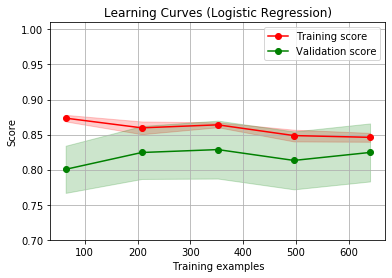

In [133]:
# Plot learning curves
title = "Learning Curves (Logistic Regression)"
cv = 10
plot_learning_curve(logreg, title, X_train_poly_selected, 
                    y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=1);

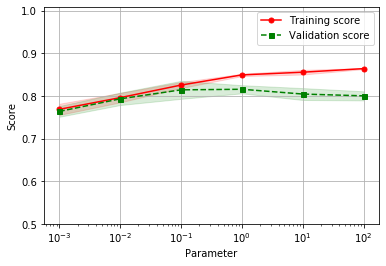

In [134]:
# Plot validation curve
title = 'Validation Curve (Logistic Regression)'
param_name = 'C'
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
cv = 10
plot_validation_curve(estimator=logreg, title=title, X=X_train_poly_selected, y=y_train, 
                      param_name=param_name, ylim=(0.5, 1.01), param_range=param_range);

# STEP (PREDICTION): Last

In [135]:
# Get test data set
df = pd.read_csv('../titanic_data/test.csv')
df_raw = df.copy()

In [136]:
# Transform data set (based on Chapter 2)

## 2.2
df['FamilySize'] = df['SibSp'] + df['Parch']
df.drop('SibSp',axis=1,inplace=True)
df.drop('Parch',axis=1,inplace=True)
df.drop(['Name','Ticket','Cabin'], axis=1, inplace=True)

df['Title']=0
for i in df:
    df['Title']=df_raw['Name'].str.extract('([A-Za-z]+)\.', expand=False)  
df_raw['Title'] = df['Title']  
means = df_raw.groupby('Title')['Age'].mean()
map_means = means.to_dict()
idx_nan_age = df.loc[np.isnan(df['Age'])].index
df.loc[idx_nan_age, 'Age'] = df['Title'].loc[idx_nan_age].map(map_means)
df['Title'] = df['Title'].map(titles_dict)
df['Title'] = pd.Categorical(df['Title'])

df['Imputed'] = 0
df.at[idx_nan_age.values, 'Imputed'] = 1

df['Age'] = pd.cut(df['Age'], bins=[0, 12, 50, 200], labels=['Child','Adult','Elder'])

## 2.3
passenger_id = df['PassengerId'].values
df.drop('PassengerId', axis=1, inplace=True)
df['Embarked'] = pd.Categorical(df['Embarked'])
df['Pclass'] = pd.Categorical(df['Pclass'])
df = pd.get_dummies(df, drop_first=1)

df = df.fillna(df.mean())  # There is one missing value in 'Fare'

X = df[df.loc[:, df.columns != 'Survived'].columns]

X_transformed = X.copy()
X_transformed['Fare'] = boxcox(X_transformed['Fare'] + 1)[0]

scaler = MinMaxScaler()
X_transformed_scaled = scaler.fit_transform(X_transformed)

poly = PolynomialFeatures(degree=2).fit(X_transformed)
X_poly = poly.transform(X_transformed_scaled)

X_poly_selected = select.transform(X_poly)

In [137]:
# Make predictions
predictions = logreg.predict(X_poly_selected)

In [138]:
# Generate submission file
submission = pd.DataFrame({ 'PassengerId': passenger_id,
                            'Survived': predictions})
submission.to_csv("submission.csv", index=False)